In [1]:
#Activity Labels
#0-Regular Sitting
#1-Regular Standing
#2-Pee Dance Sitting
#3-Pee Dance Standing

# Imports

In [2]:
from datetime import date

today = date.today()
print("Last updated on", today)

Last updated on 2024-11-24


In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

import os

Mounted at /content/drive/


In [4]:
root_dir = "/content/drive/My Drive/Enuresis Monitor Team Folder/"
project_dir = root_dir + "Sensor Data/WitMotion-Accelerometer/data from 11 20/"
data_dir = project_dir + ".csv files/"
pee_dance_dir = data_dir + "pee dance/"
regular_dir = data_dir + "regular/"
os.chdir(project_dir)

In [19]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import scipy.stats as stats
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Data Processing

In [6]:
#Read in data
reg_stand = pd.read_csv(regular_dir + "standing-20241120080844.csv").dropna(axis=0) #Regular data
reg_sitting = pd.read_csv(regular_dir + "sitting-20241120081050.csv").dropna(axis=0)

pee_sit = pd.read_csv(pee_dance_dir + "sittingpeedance-20241120081124.csv").dropna(axis=0) #Pee Dance data
pee_stand = pd.read_csv(pee_dance_dir + "standingpeedance-20241120080948.csv").dropna(axis=0)

In [7]:
#Convert time column to datetimes (for comparison)
reg_stand['time'] = pd.to_datetime(reg_stand['time'])
reg_sitting['time'] = pd.to_datetime(reg_sitting['time'])
pee_stand['time'] = pd.to_datetime(pee_stand['time'])
pee_sit['time'] = pd.to_datetime(pee_sit['time'])

In [8]:
#Create reference time column
reg_stand['time_reference'] = (reg_stand['time'] - reg_stand['time'][0]).dt.total_seconds()
reg_sitting['time_reference'] = (reg_sitting['time'] - reg_sitting['time'][0]).dt.total_seconds()

pee_stand['time_reference'] = (pee_stand['time'] - pee_stand['time'][0]).dt.total_seconds()
pee_sit['time_reference'] = (pee_sit['time'] - pee_sit['time'][0]).dt.total_seconds()

In [9]:
#Replace time with reference time for standardization
reg_stand['time'] = reg_stand['time_reference']
reg_sitting['time'] = reg_sitting['time_reference']
pee_stand['time'] = pee_stand['time_reference']
pee_sit['time'] = pee_sit['time_reference']

reg_stand.drop('time_reference', axis=1, inplace=True)
reg_sitting.drop('time_reference', axis=1, inplace=True)
pee_stand.drop('time_reference', axis=1, inplace=True)
pee_sit.drop('time_reference', axis=1, inplace=True)

In [10]:
#Pull out columns of interest
reg_stand = reg_stand[['time', 'AccX(g)', 'AccY(g)', 'AccZ(g)', 'Classification']]
reg_sitting = reg_sitting[['time', 'AccX(g)', 'AccY(g)', 'AccZ(g)', 'Classification']]
pee_sit = pee_sit[['time', 'AccX(g)', 'AccY(g)', 'AccZ(g)', 'Classification']]
pee_stand = pee_stand[['time', 'AccX(g)', 'AccY(g)', 'AccZ(g)', 'Classification']]

# Representative Statistics

In [11]:
#A(X) Analysis
print("Mean X accelerations....")
print("Normal Standing: ", reg_stand['AccX(g)'].mean())
print("Wiggle Dance Standing: ",pee_stand['AccX(g)'].mean())
print(" ")
print("Normal Sitting: ",reg_sitting['AccX(g)'].mean())
print("Wiggle Dance Sitting: ",pee_sit['AccX(g)'].mean())

Mean X accelerations....
Normal Standing:  -0.0012805555555555558
Wiggle Dance Standing:  0.18147456445993032
 
Normal Sitting:  0.9686017316017316
Wiggle Dance Sitting:  0.8632138228941684


In [12]:
#A(Y) Analysis
print("Mean Y accelerations....")
print("Normal Standing: ", reg_stand['AccY(g)'].mean())
print("Wiggle Dance Standing: ",pee_stand['AccY(g)'].mean())
print(" ")
print("Normal Sitting: ",reg_sitting['AccY(g)'].mean())
print("Wiggle Dance Sitting: ",pee_sit['AccY(g)'].mean())

Mean Y accelerations....
Normal Standing:  0.1089925925925926
Wiggle Dance Standing:  0.018068989547038325
 
Normal Sitting:  -0.22874891774891776
Wiggle Dance Sitting:  -0.18383729301655868


In [13]:
#A(Z) Analysis
print("Mean Z accelerations....")
print("Normal Standing: ", reg_stand['AccZ(g)'].mean())
print("Wiggle Dance Standing: ",pee_stand['AccZ(g)'].mean())
print(" ")
print("Normal Sitting: ",reg_sitting['AccZ(g)'].mean())
print("Wiggle Dance Sitting: ",pee_sit['AccZ(g)'].mean())

Mean Z accelerations....
Normal Standing:  0.989247222222222
Wiggle Dance Standing:  1.0830285714285715
 
Normal Sitting:  1.0123751803751804
Wiggle Dance Sitting:  1.0528502519798417


# Machine Learning Algorithm

XGBoost

In [14]:
#Combine data into one for train-test K-fold splits
combined_data = pd.concat([reg_stand, reg_sitting, pee_stand, pee_sit], ignore_index=True)

In [15]:
print(len(combined_data))

5290


In [25]:
#Set up training and test sets for K-fold testing
features = combined_data.drop(columns='Classification')
labels = combined_data['Classification']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
pearsons = []
accuracies = []
#Running 5-fold XGBoost
for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_test, label=y_test)

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'seed': 42
    }

    model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], verbose_eval=False)
    y_pred = model.predict(dval)
    accuracy = accuracy_score(y_test, y_pred.round())
    mse = mean_squared_error(y_test, y_pred)
    correlation, p_val = stats.pearsonr(y_test, y_pred)

    accuracies.append(accuracy)
    pearsons.append(correlation)
    mse_scores.append(mse)

average_accuracy = np.mean(accuracies)
average_mse = np.mean(mse_scores)
average_correlation = np.mean(pearsons)
print(f'Average Accuracy from 5-fold Cross-Validation using XGBoost: {average_accuracy}')
print(f'Average RMSE from 5-fold Cross-Validation using XGBoost: {np.sqrt(average_mse)}')
print(f'Average Pearson correlation from 5-fold Cross-Validation using XGBoost: {average_correlation}')

NameError: name 'ytest' is not defined

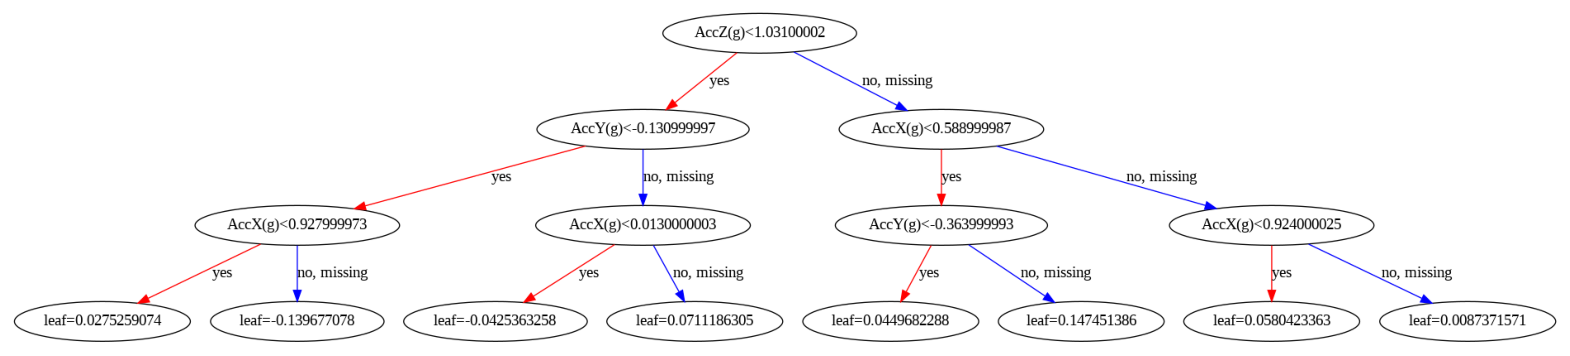

In [20]:
xgb.plot_tree(model, num_trees=0, fmap='', rankdir='UT')
plt.gcf().set_size_inches(20, 10)  # Increase plot size
plt.show()

In [27]:
print(y_pred)

[1.8409961 1.3029776 1.0212374 ... 2.0084536 2.0272455 2.0272455]
